Project path + Imports + Config

In [35]:
# -- Make the project root importable so "from src..." works --
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from src.utils import load_config

# Load config
CFG_PATH = os.path.join(PROJECT_ROOT, "configs", "baseline.yaml")
cfg = load_config(CFG_PATH)

print("Loaded config from", CFG_PATH)
print("Data root:", cfg.data.root)
print("Image ext:", cfg.data.img_ext)
print("Mask ext:", cfg.data.mask_ext)
print("Mask suffix:", cfg.data.get("mask_suffix", ""))

Loaded config from /Users/jonatantobon/Documents/kaggle-sci-image-forgery-seg/configs/baseline.yaml
Data root: data/raw
Image ext: .png
Mask ext: .npy
Mask suffix: 


Define Folders to visualize (Train or Val)

In [36]:
# Choose split: "train" or "val"
SPLIT = "train"

IMG_DIR = os.path.join(PROJECT_ROOT, cfg.data.root, cfg.data[f"{SPLIT}_images_dir"])
MSK_DIR = os.path.join(PROJECT_ROOT, cfg.data.root, cfg.data[f"{SPLIT}_masks_dir"])

IMG_EXT = cfg.data.img_ext
MSK_EXT = cfg.data.mask_ext
MSK_SUFFIX = cfg.data.get("mask_suffix", "")

print("IMG_DIR", IMG_DIR)
print("MSK_DIR", MSK_DIR)
print("IMG_EXT", IMG_EXT, "| MSK_EXT:", MSK_EXT, "| MSK_SUFFIX:", MSK_SUFFIX)

IMG_DIR /Users/jonatantobon/Documents/kaggle-sci-image-forgery-seg/data/raw/train/images
MSK_DIR /Users/jonatantobon/Documents/kaggle-sci-image-forgery-seg/data/raw/train/masks
IMG_EXT .png | MSK_EXT: .npy | MSK_SUFFIX: 


Helpers to load images/masks + overlay

In [37]:
def read_img_rgb(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_mask(path: str, ext: str) -> np.ndarray:
    ext = ext.lower()
    if ext == ".npy":
        m = np.load(path)
        if m.ndim == 3:
            m = m[..., 0]
        m = m.astype(np.float32)
        m = (m > 0.5).astype(np.uint8)
        return m
    else: 
        m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(f"Could not read mask: {path}")
        return (m > 0).astype(np.uint8)

def overlay_red(img_rgb: np.ndarray, mask01: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    # Mask01 is {0,1}
    ov = img_rgb.copy()
    red = np.zeros_like(img_rgb)
    red[..., 0] = 255 # R channel
    m3 = np.repeat(mask01[..., None].astype(bool), 3, axis=2)
    ov[m3] = (alpha * red[m3] + (1 - alpha) * ov[m3]).astype(np.uint8)
    return ov

Find Valid (image, mask) pairs

In [39]:
img_paths = sorted(glob(os.path.join(IMG_DIR, "*" + IMG_EXT)))
if len(img_paths) == 0:
    raise RuntimeError(f"No images found in {IMG_DIR} with ext {IMG_EXT}")

stems = [os.path.splitext(os.path.basename(p))[0] for p in img_paths]

pairs = []
missing_masks = []
for s in stems:
    mp = os.path.join(MSK_DIR, f"{s}{MSK_SUFFIX}{MSK_EXT}")
    if os.path.exists(mp):
        pairs.append((s, os.path.join(IMG_DIR, s + IMG_EXT), mp))
    else:
        missing_masks.append(mp)

print("Images found:", len(img_paths))
print("Pairs found :", len(pairs))
print("Missing masks (first 5):")
for x in missing_masks[:5]:
    print(" -", x)

if len(pairs) == 0:
    raise RuntimeError("No valid pairs found. Check mask_ext/mask_suffix and filenames.")

Images found: 9
Pairs found : 9
Missing masks (first 5):


Print dataset stats (shapes, dtypes, mask coverage)

In [40]:
def summarize_pairs(stem, ip, mp):
    img = read_img_rgb(ip)
    msk = read_mask(mp, MSK_EXT)

    # Align if needed
    if img.shape[:2] != msk.shape[:2]:
        msk =cv2.resize(msk, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    frac = float(msk.mean()) # Because mask is 0/1
    return {
        "stem": stem, 
        "img_shape": img.shape,
        "img_dtype": str(img.dtype),
        "mask_shape":msk.shape,
        "mask_dtype": str(msk.dtype),
        "mask_fg_frac": frac,
    }

for stem, ip, mp in pairs[:10]:
    info = summarize_pairs(stem, ip, mp)
    print(info)

{'stem': '10', 'img_shape': (512, 648, 3), 'img_dtype': 'uint8', 'mask_shape': (512, 648), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '156', 'img_shape': (1200, 1600, 3), 'img_dtype': 'uint8', 'mask_shape': (1200, 1600), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '176', 'img_shape': (85, 517, 3), 'img_dtype': 'uint8', 'mask_shape': (85, 517), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '187', 'img_shape': (877, 802, 3), 'img_dtype': 'uint8', 'mask_shape': (877, 802), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '209', 'img_shape': (1501, 233, 3), 'img_dtype': 'uint8', 'mask_shape': (1501, 233), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.09871244635193133}
{'stem': '230', 'img_shape': (3888, 2592, 3), 'img_dtype': 'uint8', 'mask_shape': (3888, 2592), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '287', 'img_shape': (343, 1021, 3), 'img_dtype': 'uint8', 'mask_shape': (343, 1021), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.2713026444662096}
{'stem':

Visualize N pairs (image + mask overlay + mask)

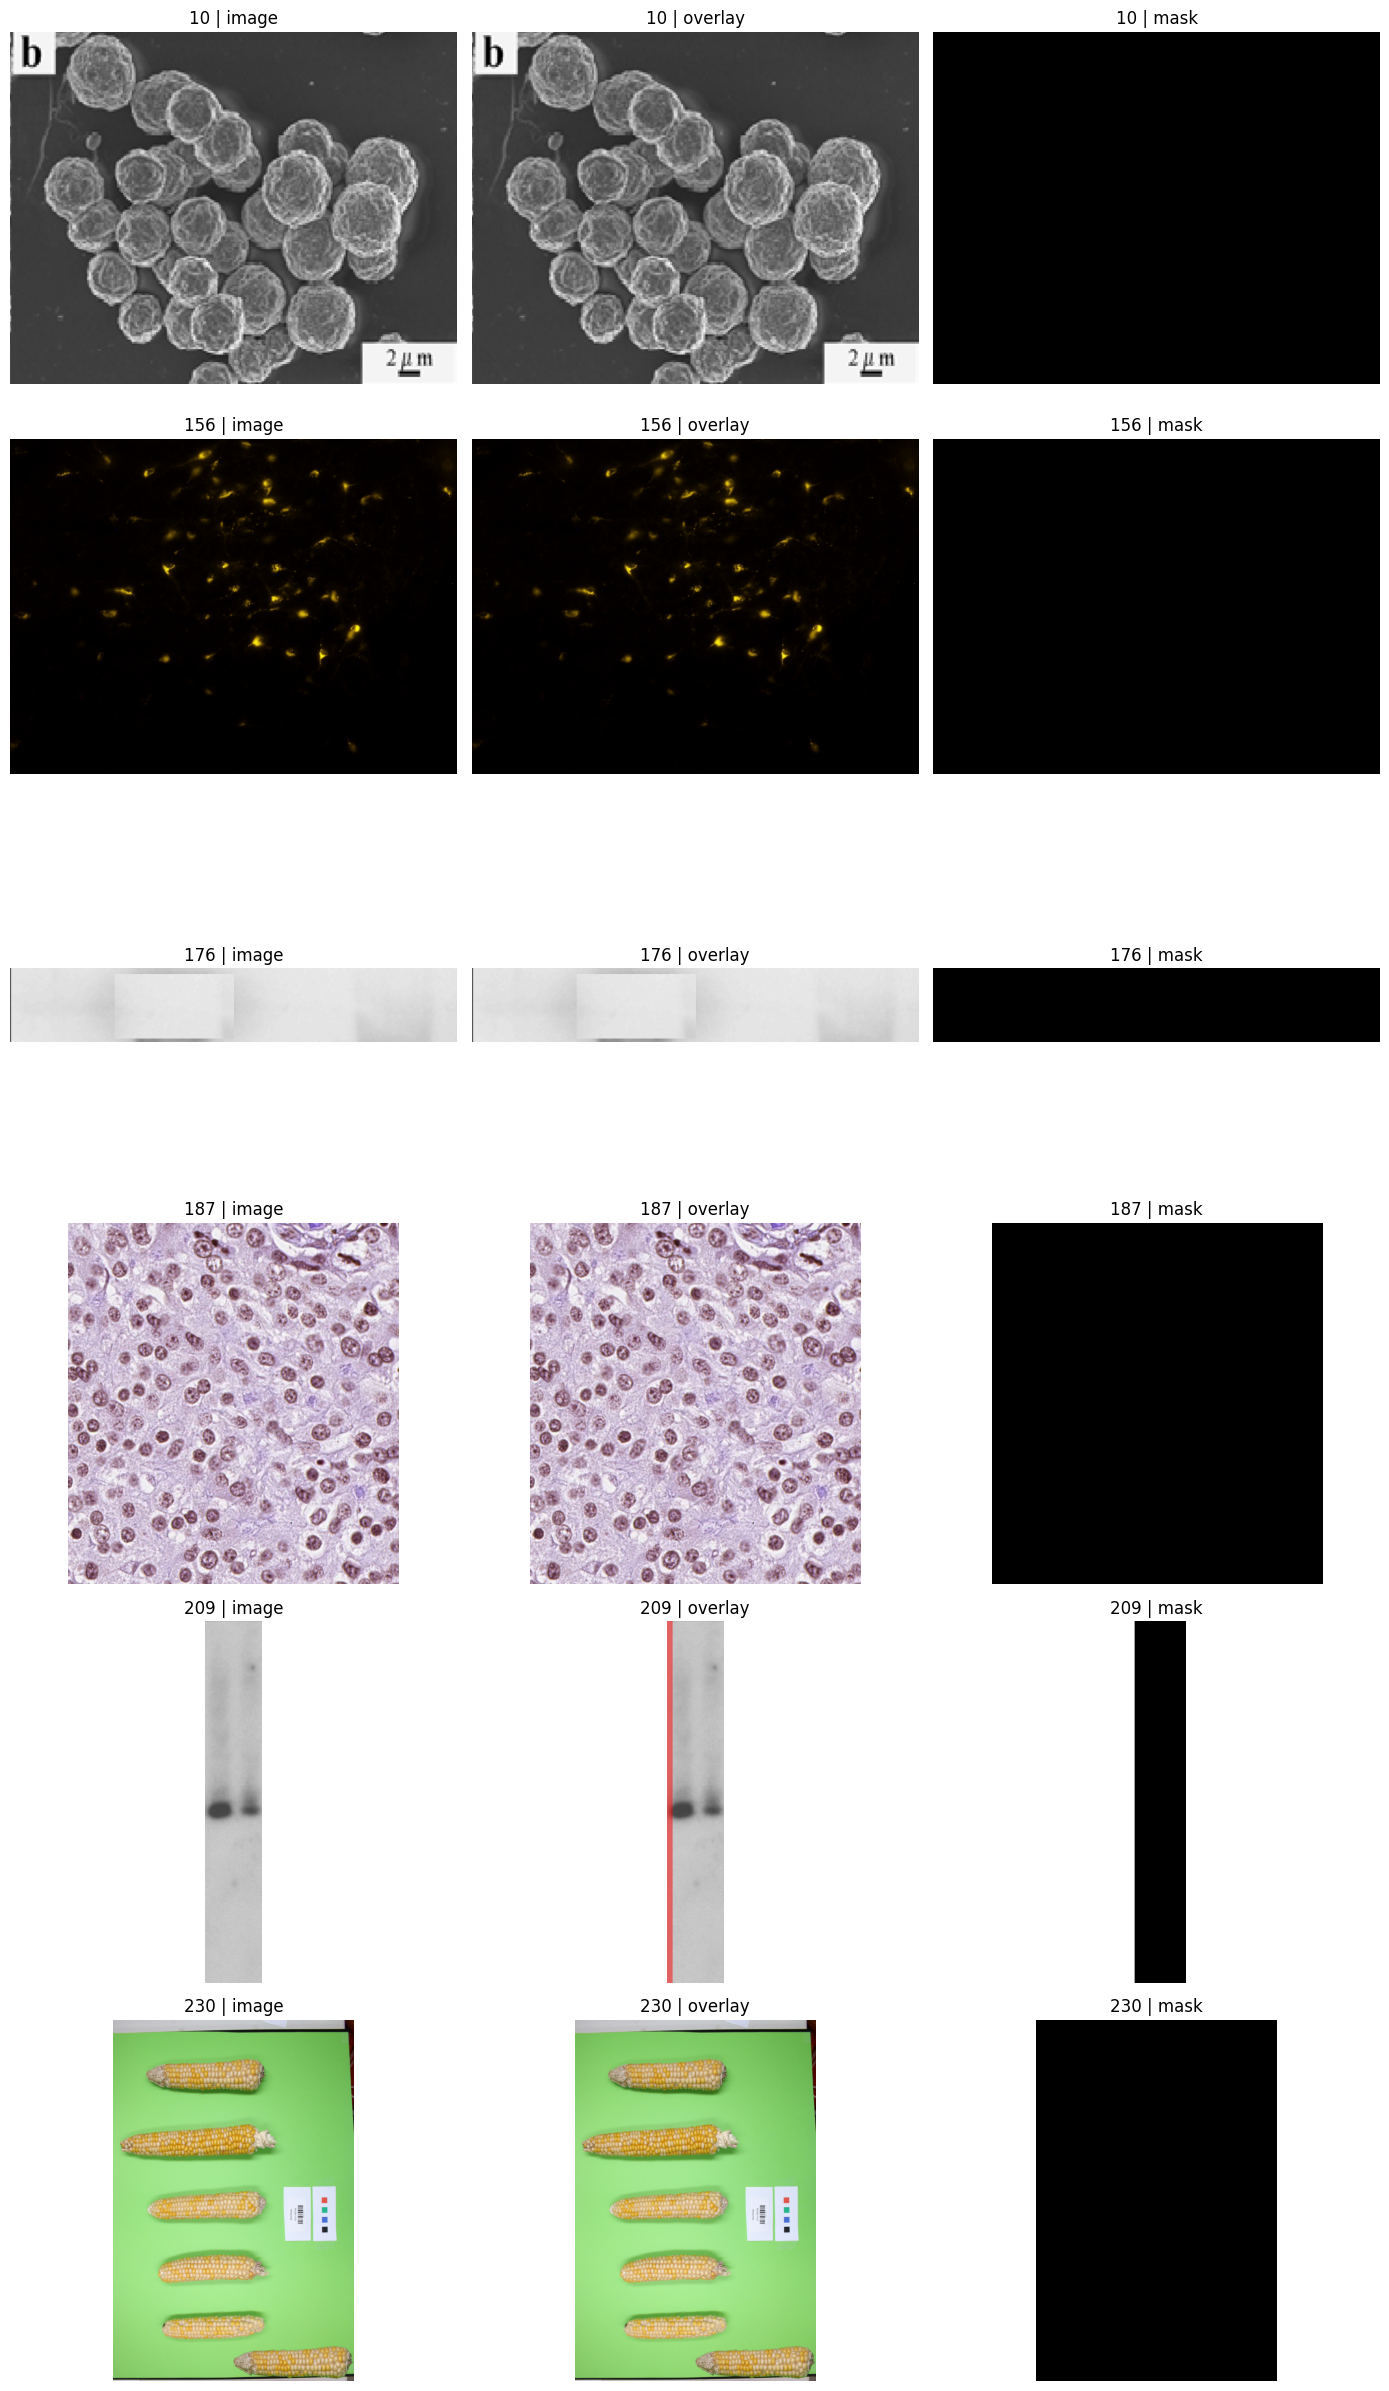

In [41]:
N = min(6, len(pairs))

plt.figure(figsize=(14, 4 * N))
for i, (stem, ip, mp) in enumerate(pairs[:N]):
    img = read_img_rgb(ip)
    msk = read_mask(mp, MSK_EXT)

    if img.shape[:2] != msk.shape[:2]:
        msk = cv2.resize(msk, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    ov = overlay_red(img, msk, alpha=0.5)

    # Image
    plt.subplot(N, 3, i*3 + 1)
    plt.imshow(img)
    plt.title(f"{stem} | image")
    plt.axis("off")

    # Overlay
    plt.subplot(N, 3, i*3 + 2)
    plt.imshow(ov)
    plt.title(f"{stem} | overlay")
    plt.axis("off")

    # Mask
    plt.subplot(N, 3, i*3 + 3)
    plt.imshow(msk, cmap="gray")
    plt.title(f"{stem} | mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

Data Dashboard

In [42]:
def scan_split(split="train", max_items=None):
    img_dir = os.path.join(PROJECT_ROOT, cfg.data.root, cfg.data[f"{split}_images_dir"])
    msk_dir = os.path.join(PROJECT_ROOT, cfg.data.root, cfg.data[f"{split}_masks_dir"])
    img_ext = cfg.data.img_ext
    msk_ext = cfg.data.mask_ext
    msk_suffix = cfg.data.get("mask_suffix", "")

    img_paths = sorted(glob(os.path.join(img_dir, "*" + img_ext)))
    if max_items:
        img_paths = img_paths[:max_items]
    
    total = 0
    empty = 0
    fg_fracs = []
    bad_shapes = 0

    for ip in img_paths:
        stem = os.path.splitext(os.path.basename(ip))[0]
        mp = os.path.join(msk_dir, f"{stem}{msk_suffix}{msk_ext}")
        if not os.path.exists(mp):
            continue

        img = read_img_rgb(ip)
        msk = read_mask(mp, msk_ext)

        # Align for stats
        if img.shape[:2] != msk.shape[:2]:
            bad_shapes += 1
            msk = cv2.resize(msk, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        frac = float(msk.mean())
        fg_fracs.append(frac)
        if frac == 0.0:
            empty += 1
        
        total += 1
    
    fg_fracs = np.array(fg_fracs) if len(fg_fracs) else np.array([0.0])
    return {
        "split": split,
        "pairs": total,
        "empty_masks": empty,
        "empty_pct": (empty / max(total, 1)) * 100.0,
        "fg_frac_mean": float(fg_fracs.mean()),
        "fg_frac_median": float(np.median(fg_fracs)),
        "fg_frac_max": float(fg_fracs.max()),
        "shape_mismatches_fixed": bad_shapes,
    }

print(scan_split("train"))
print(scan_split("val"))

{'split': 'train', 'pairs': 9, 'empty_masks': 7, 'empty_pct': 77.77777777777779, 'fg_frac_mean': 0.041112787868682325, 'fg_frac_median': 0.0, 'fg_frac_max': 0.2713026444662096, 'shape_mismatches_fixed': 9}
{'split': 'val', 'pairs': 6, 'empty_masks': 4, 'empty_pct': 66.66666666666666, 'fg_frac_mean': 0.06166918180302349, 'fg_frac_median': 0.0, 'fg_frac_max': 0.2713026444662096, 'shape_mismatches_fixed': 6}


Compare GT vs Prediction

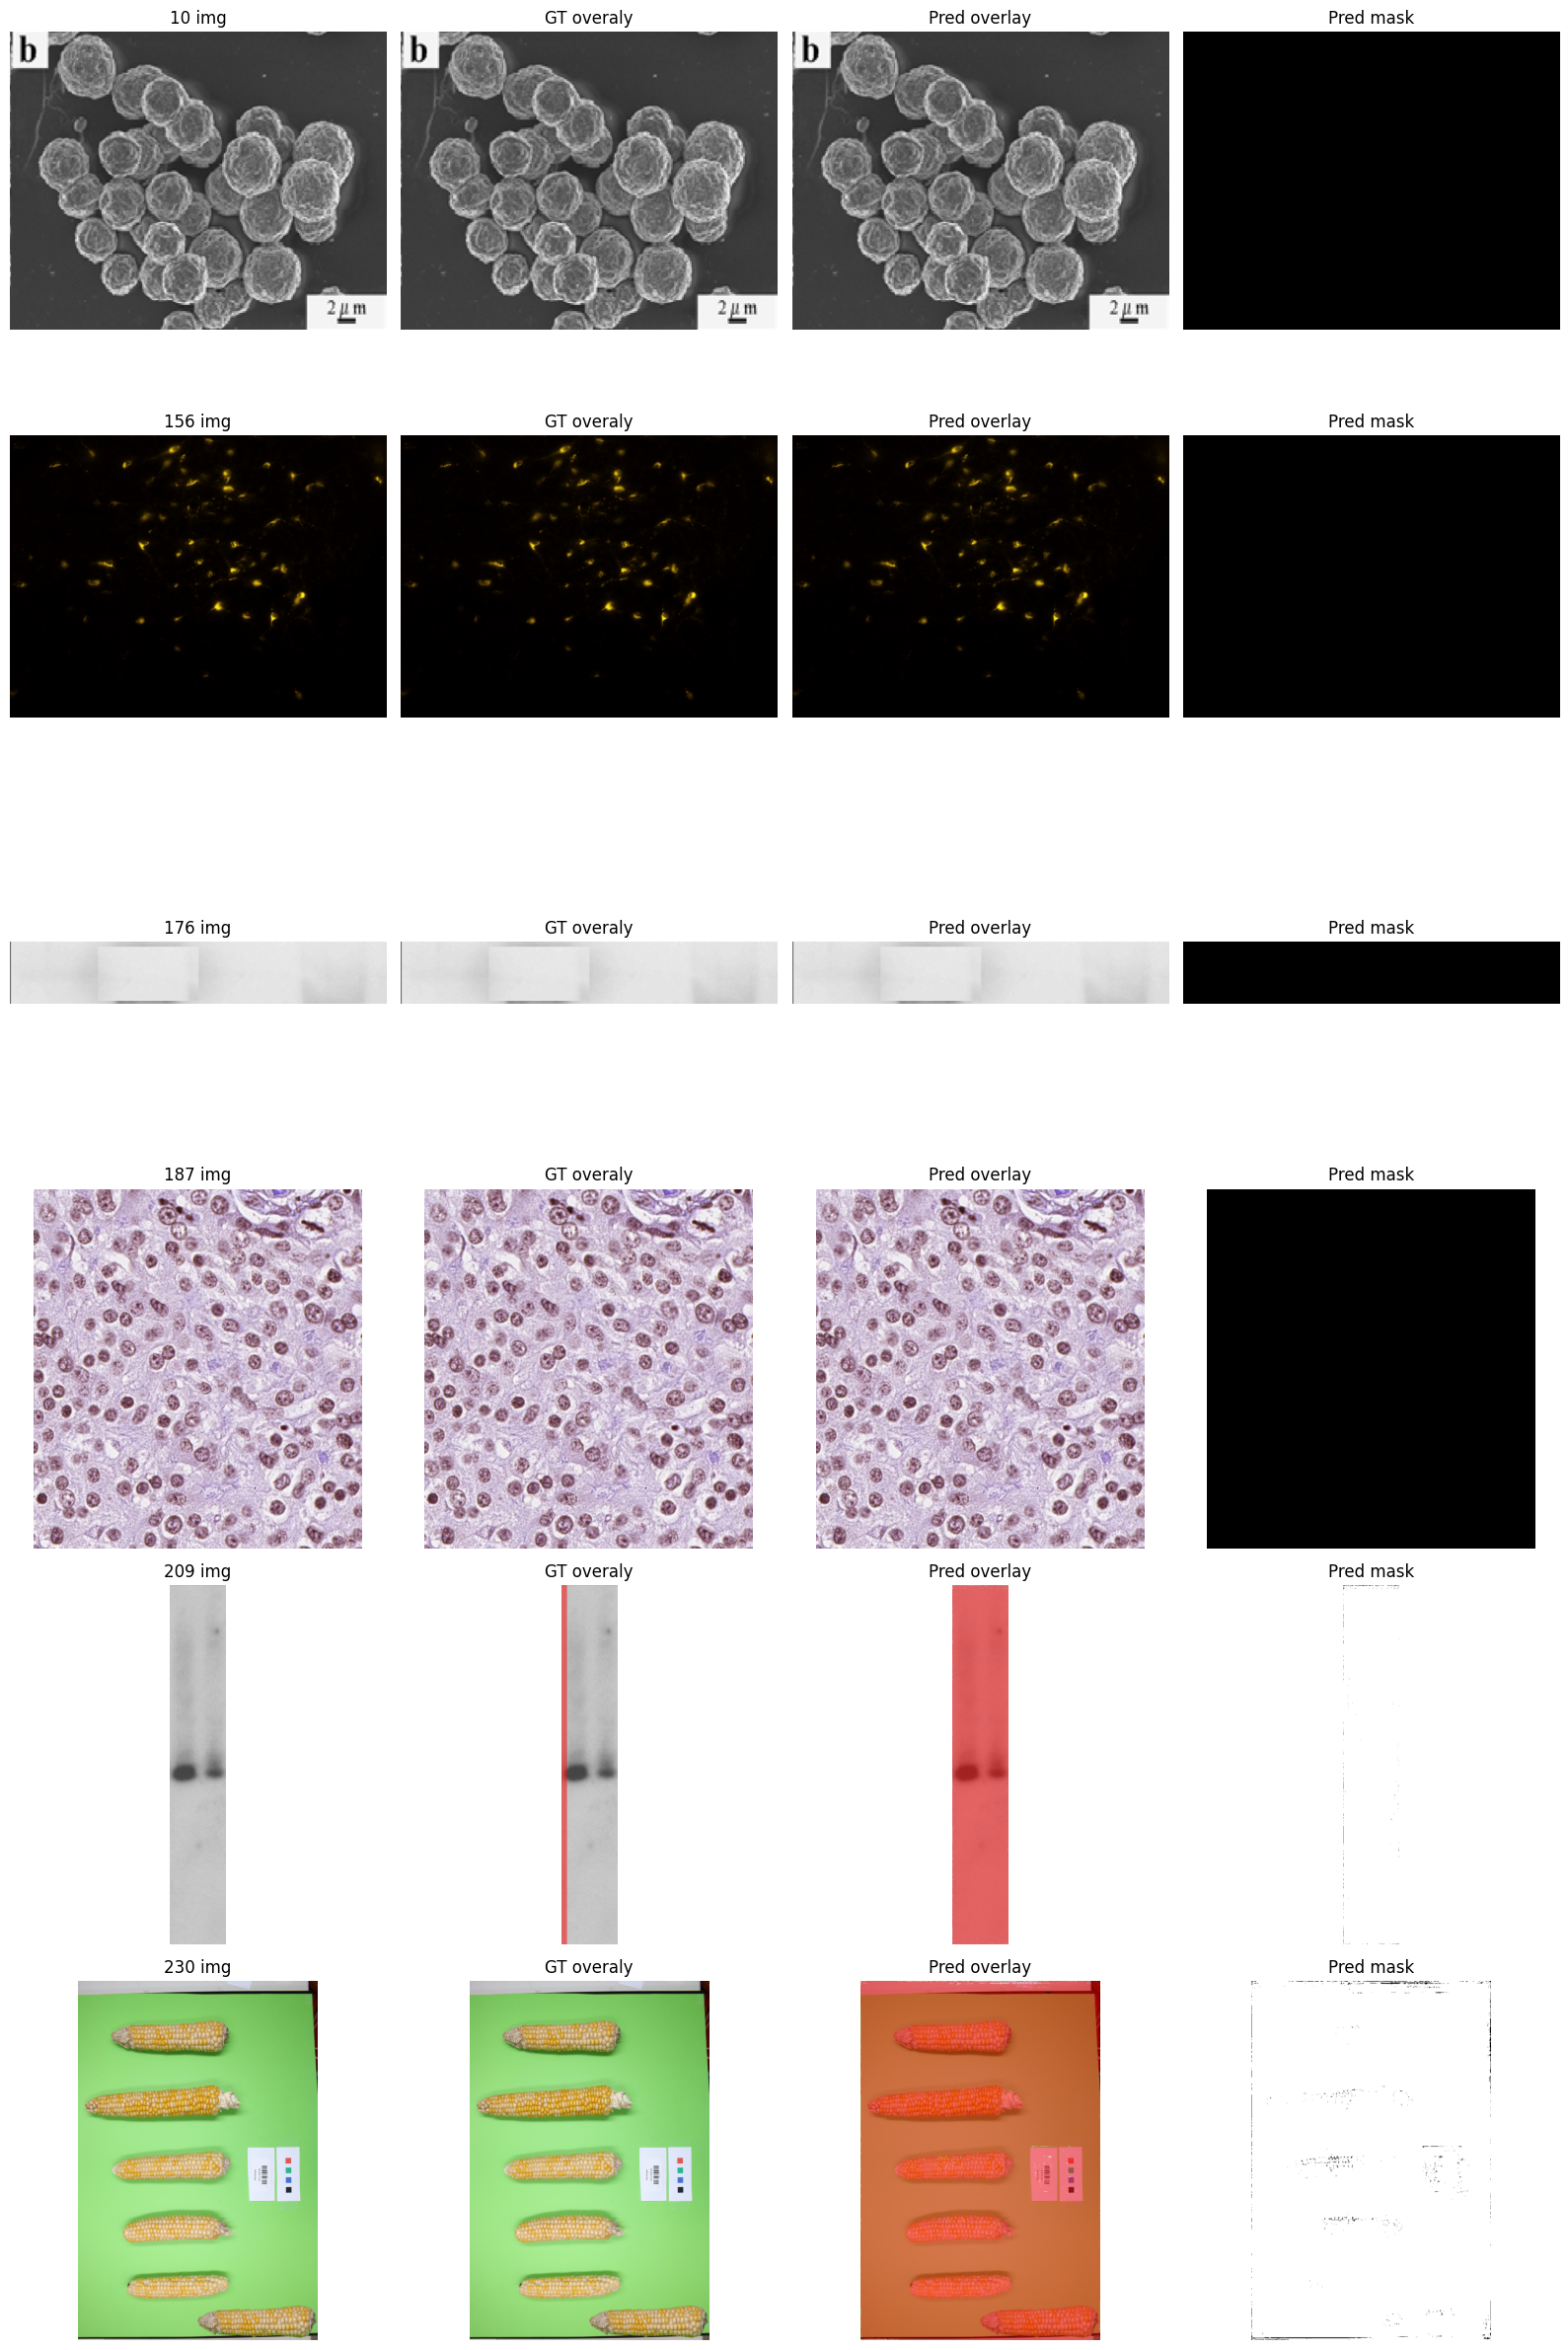

In [43]:
import os, cv2, numpy as np, matplotlib.pyplot as plt

PRED_DIR = os.path.join(PROJECT_ROOT, "outputs", "preds", "val")

def read_pred_mask_png(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(path)
    return (m > 127).astype(np.uint8)

def overlay_red(img_rgb, mask01, alpha=0.5):
    ov = img_rgb.copy()
    red = np.zeros_like(img_rgb); red[..., 0] = 255
    m3 = np.repeat(mask01[..., None].astype(bool), 3, axis=2)
    ov[m3] = (alpha*red[m3] + (1-alpha)*ov[m3]).astype(np.uint8)
    return ov

N = min(6, len(pairs))
plt.figure(figsize=(16, 4*N))

for i, (stem, ip, mp) in enumerate(pairs[:N]):
    img = read_img_rgb(ip)
    gt = read_mask(mp, MSK_EXT)
    if img.shape[:2] != gt.shape[:2]:
        gt = cv2.resize(gt, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    pred_path = os.path.join(PRED_DIR, f"{stem}.png")
    pred = read_pred_mask_png(pred_path) if os.path.exists(pred_path) else np.zeros(gt.shape, dtype=np.uint8)

    gt_ov = overlay_red(img, gt, alpha=0.5)
    pr_ov = overlay_red(img, pred, alpha=0.5)

    plt.subplot(N, 4, i*4+1); plt.imshow(img); plt.title(f"{stem} img"); plt.axis("off")
    plt.subplot(N, 4, i*4+2); plt.imshow(gt_ov); plt.title(f"GT overaly"); plt.axis("off")
    plt.subplot(N, 4, i*4+3); plt.imshow(pr_ov); plt.title(f"Pred overlay"); plt.axis("off")
    plt.subplot(N, 4, i*4+4); plt.imshow(pred, cmap="gray"); plt.title(f"Pred mask"); plt.axis("off")

plt.tight_layout()
plt.show()

More Stats

In [44]:
def dice(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    return (2*inter) / (a.sum() + b.sum() + 1e-6)

scores = []
for stem, ip, mp in pairs:
    img = read_img_rgb(ip)
    gt = read_mask(mp, MSK_EXT)
    if img.shape[:2] != gt.shape[:2]:
        gt = cv2.resize(gt, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    pred_path = os.path.join(PRED_DIR, f"{stem}.png")
    if not os.path.exists(pred_path):
        continue
    pred = read_pred_mask_png(pred_path)

    scores.append((stem, float(gt.mean()), float(pred.mean()), float(dice(gt, pred))))

scores[:10], np.mean([s[-1] for s in scores]) if scores else None

([('209', 0.09871244635193133, 0.9970577554877578, 0.1771795828577392),
  ('230', 0.0, 0.9930638907940863, 0.0),
  ('287', 0.2713026444662096, 0.9963392660828149, 0.4260292116801086)],
 np.float64(0.2010695981792826))

Computing Dice/IoU

In [48]:
import os, cv2, numpy as np

PRED_DIR = os.path.join(PROJECT_ROOT, "outputs", "preds", "train")

def read_pred(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        return None
    return (m > 127).astype(np.uint8)

def dice(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    return (2 * inter) / (a.sum() + b.sum() + 1e-6)

def iou(a, b):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    union = (a | b).sum()
    return inter / (union + 1e-6)

rows = []
for stem, ip, mp in pairs:
    img = read_img_rgb(ip)
    gt  = read_mask(mp, MSK_EXT)
    if img.shape[:2] != gt.shape[:2]:
        gt = cv2.resize(gt, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    pred_path = os.path.join(PRED_DIR, f"{stem}.png")
    pred = read_pred(pred_path)
    if pred is None:
        continue

    rows.append((stem, float(gt.mean()), float(pred.mean()), float(dice(gt, pred)), float(iou(gt, pred))))

rows

[('10', 0.0, 0.9918800636574074, 0.0, 0.0),
 ('156', 0.0, 0.9921192708333333, 0.0, 0.0),
 ('176', 0.0, 0.9901240186596882, 0.0, 0.0),
 ('187', 0.0, 0.989449125191582, 0.0, 0.0),
 ('209',
  0.09871244635193133,
  0.9970577554877578,
  0.1771795828577392,
  0.09720078905826264),
 ('230', 0.0, 0.9930638907940863, 0.0, 0.0),
 ('287',
  0.2713026444662096,
  0.9963392660828149,
  0.4260292116801086,
  0.2706716127399456),
 ('57', 0.0, 0.98990478515625, 0.0, 0.0),
 ('90', 0.0, 0.9900145833333334, 0.0, 0.0)]